In [20]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_v, n_clust_obs_f_v_val
from src.python.visualization import perf_tester_over_obs

import numpy as np
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [5]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [6]:
# Cosine Decay with Restarts

initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    skip_checks=True
    )

In [7]:
n_obs_min = 1 
n_obs_max = 100

# Train & validate

In [8]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=1, iterations_per_epoch=1000, batch_size=32, 
    n_obs=partial(n_clust_obs_f_v, n_obs_min, n_obs_max)
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# Validation

# Generate data for each setting
#n_val_per_setting = 5000
n_val_per_setting = 50

m_val = []
x_val = []

for n in range(n_obs_min, n_obs_max+1):
    m_val_sim, _, x_val_sim = simulator(n_val_per_setting, n_clust_obs_f_v_val(n))
    m_val.append(m_val_sim)
    x_val.append(x_val_sim)
    if n%25 == 0:
        print('Iteration {} finished'.format(n))

val_data = {'X' : x_val, 'm' : m_val}

Iteration 25 finished
Iteration 50 finished
Iteration 75 finished
Iteration 100 finished


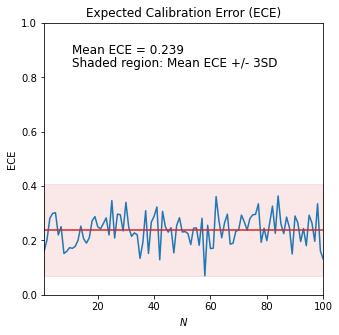

In [21]:
# Plot validation results
perf_tester_over_obs(evidence_net, summary_net, val_data, n_obs_min, n_obs_max)

[0.1613736612684685, 0.20300380992844247, 0.2814129077012722, 0.2995793608327707, 0.30208328398210665]


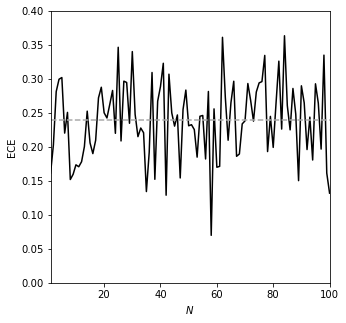

In [22]:
# Plot validation results publication-ready
perf_tester_over_obs(evidence_net, summary_net, val_data, n_obs_min, n_obs_max, pub_style=True)

# Calculate Bayes factors for bridge sampling comparison

In [ ]:
#TODO: 
# Generate comparison datasets in bridge sampling comparison notebook
# import here 
# apply get_preds_and_bfs from helpers (TODO)
# export results via function from helpers (TODO)